In [1]:
import tensorflow as tf
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras.losses import BinaryCrossentropy, Loss
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import BinaryAccuracy
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

2023-11-08 13:07:02.392607: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 13:07:02.392638: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 13:07:02.392684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 13:07:02.399496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CONFIGURATION = {
    "N_FILTER":16,
    "IM_SIZE":224,
    "BATCH SIZE":32,
    "N_EPOCH":50,
    "SHUFFLE_SIZE":256
}

In [3]:
train_images_fire_path = './dataset/train_image/Fire/'
train_images_non_fire_path = './dataset/train_image/Not_Fire/'
train_mask_fire_path = './dataset/train_mask/Fire/'
# train_mask_non_fire_path = 'None'

val_images_fire_path = './dataset/val_image/Fire/'
val_iamges_non_fire_path = './dataset/val_image/Not_Fire/'
val_mask_fire_path = './dataset/val_mask/Fire/'

In [4]:
train_image_paths = []
train_mask_paths = []

val_image_paths = []
val_mask_paths = []

for i in os.listdir(train_images_fire_path):
    train_image_paths.append(train_images_fire_path+i)
    train_mask_paths.append(train_mask_fire_path+i)

for i in os.listdir(train_images_non_fire_path):
    train_image_paths.append(train_images_non_fire_path+i)
    train_mask_paths.append('None')

for i in os.listdir(val_images_fire_path):
    val_image_paths.append(val_images_fire_path+i)
    val_mask_paths.append(val_mask_fire_path+i)

for i in os.listdir(val_iamges_non_fire_path):
    val_image_paths.append(val_iamges_non_fire_path+i)
    val_mask_paths.append('None')

In [5]:
print(train_image_paths[-1])
print(train_mask_paths[-1])

print(len(train_image_paths))
print(len(train_mask_paths))

print(val_image_paths[450])
print(val_mask_paths[450])

print(len(val_image_paths))
print(len(val_mask_paths))

./dataset/train_image/Not_Fire/Img_32453.jpg
None
38262
38262
./dataset/val_image/Not_Fire/Img_3988.jpg
None
590
590


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

2023-11-08 13:07:08.400338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 13:07:08.407063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 13:07:08.407287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
def import_image(im_path, mask_path):
    image = cv2.imread(str(im_path)[2:-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    image = np.expand_dims(image, -1)
    image = image/255

    if str(mask_path)[2:-1]=='None':
        mask_image = np.zeros(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    else:
        mask_image = cv2.imread(str(mask_path)[2:-1])
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
        mask_image = cv2.resize(mask_image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
        mask_image = np.expand_dims(mask_image, -1)
        mask_image = mask_image/255

    return tf.convert_to_tensor(image, dtype=tf.float32), tf.convert_to_tensor(mask_image, dtype=tf.float32)

In [8]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

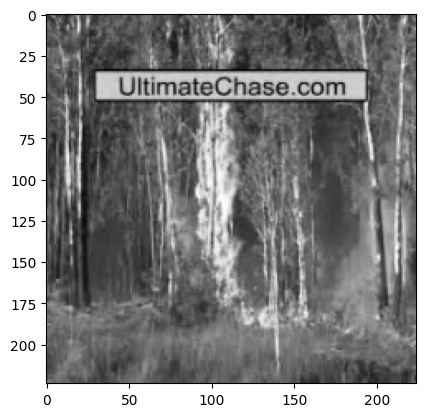

In [9]:
for i, j in val_dataset.take(1):
    img, mask = import_image(i.numpy(), j.numpy())
    # print(img.shape, mask.shape)
    img = np.array((img+1)*127.5, dtype=np.uint8)
    plt.imshow(img, cmap='grey')
    # print(np.min(img))

In [10]:
def cv_read(im_path, mask_path):
    img, mask = tf.numpy_function(import_image, inp=[im_path, mask_path], Tout=[tf.float32, tf.float32])
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    mask = tf.reshape(mask, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))
    return img, mask

In [11]:
val_dataset = val_dataset.map(cv_read)
train_dataset = train_dataset.map(cv_read)

In [12]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float32, name=None))>

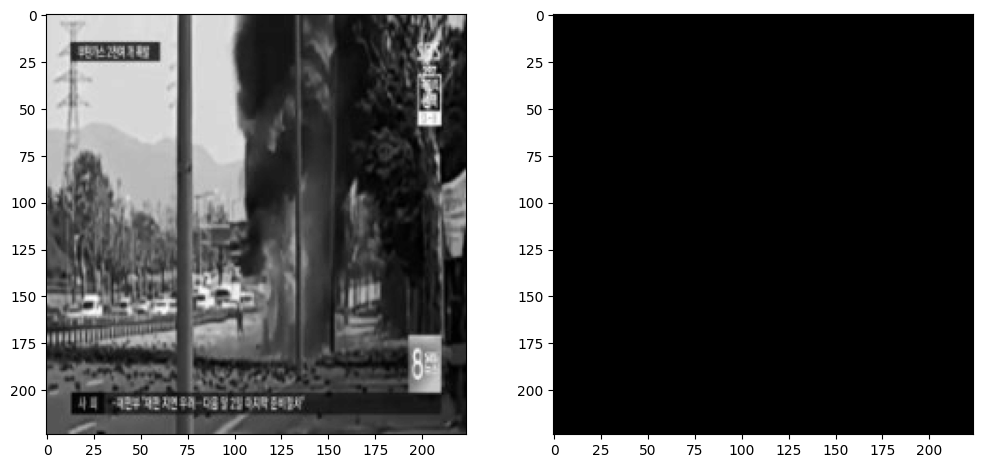

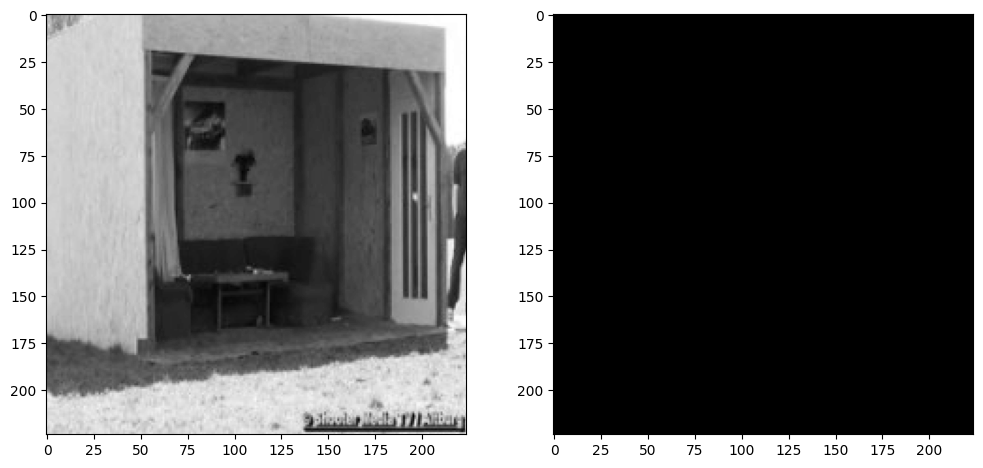

In [13]:
k = 1
for i, j in val_dataset.skip(451).take(2):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, k)
    plt.imshow(np.array((i+1)*127.5, dtype=np.uint8), cmap='grey')
    plt.subplot(2, 2, k+1)
    plt.imshow(np.array((j+1)*127.5, dtype=np.uint8), cmap='grey')
    k+=2

In [14]:
train_dataset = (train_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                 .shuffle(CONFIGURATION['SHUFFLE_SIZE'], reshuffle_each_iteration=False)
                 .prefetch(tf.data.AUTOTUNE))

In [15]:
val_dataset = (val_dataset
                 .batch(CONFIGURATION['BATCH SIZE'])
                #  .shuffle(128, reshuffle_each_iteration=False)
                 .prefetch(tf.data.AUTOTUNE))

In [16]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None))>

# Model

In [17]:
def double_conv_block(x, n_filters):
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)

    return x

In [18]:
def downSample_block(x, n_filters):
    conv_out = double_conv_block(x, n_filters)
    pool = MaxPooling2D(pool_size=(2, 2))(conv_out)
    drop = Dropout(0.25)(pool)

    return conv_out, drop

In [19]:
def upsample_block(x, conv_out, n_filters):
    x = Conv2DTranspose(n_filters, (3, 3), (2, 2), padding='same')(x)
    x = concatenate([x, conv_out])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [20]:
input = Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 1))

conv1, drop1 = downSample_block(input, CONFIGURATION['N_FILTER']*1)
conv2, drop2 = downSample_block(drop1, CONFIGURATION['N_FILTER']*2)
conv3, drop3 = downSample_block(drop2, CONFIGURATION['N_FILTER']*4)
conv4, drop4 = downSample_block(drop3, CONFIGURATION['N_FILTER']*8)

bottleneck = double_conv_block(drop4, CONFIGURATION['N_FILTER']*16)

uconv4 = upsample_block(bottleneck, conv4, CONFIGURATION['N_FILTER']*8)
uconv3 = upsample_block(uconv4, conv3, CONFIGURATION['N_FILTER']*4)
uconv2 = upsample_block(uconv3, conv2, CONFIGURATION['N_FILTER']*2)
uconv1 = upsample_block(uconv2, conv1, CONFIGURATION['N_FILTER']*1)

output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(uconv1)

model = Model(input, output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [21]:
class Custom_loss(Loss):

  def call(self, y_true, y_pred):
      return tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))


In [22]:
model.compile(
    optimizer=Adam(),
    loss = Custom_loss(),
    metrics=[BinaryAccuracy()]
)

In [23]:
save_model = [
    # ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('unet_model_new.keras', verbose=1, save_best_only=True, save_weights_only=True)
]

In [24]:
model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1, callbacks=[save_model])

Epoch 1/5


2023-11-08 13:07:52.566261: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-08 13:08:02.946064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 142 of 256
2023-11-08 13:08:10.986214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-11-08 13:08:11.007611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-08 13:08:14.944686: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 677.57MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-08 13:08:15.127571: W tensorfl

   3/1196 [..............................] - ETA: 10:35 - loss: 48255.0820 - binary_accuracy: 0.1013 

2023-11-08 13:08:25.826289: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 614.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1196/1196 [==============================] - ETA: 0s - loss: 175690.5000 - binary_accuracy: 0.9753
Epoch 1: val_loss improved from inf to 2671.07495, saving model to unet_model_new.keras
1196/1196 [==============================] - 717s 571ms/step - loss: 175690.5000 - binary_accuracy: 0.9753 - val_loss: 2671.0750 - val_binary_accuracy: 0.9838
Epoch 2/5


2023-11-08 13:20:24.837430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 133 of 256
2023-11-08 13:20:34.197939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 3075.9048 - binary_accuracy: 0.9783
Epoch 2: val_loss improved from 2671.07495 to 2535.38599, saving model to unet_model_new.keras
1196/1196 [==============================] - 706s 574ms/step - loss: 3075.9048 - binary_accuracy: 0.9783 - val_loss: 2535.3860 - val_binary_accuracy: 0.9838
Epoch 3/5


2023-11-08 13:32:10.363482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 112 of 256
2023-11-08 13:32:23.611872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 2814.1240 - binary_accuracy: 0.9784
Epoch 3: val_loss did not improve from 2535.38599
1196/1196 [==============================] - 723s 585ms/step - loss: 2814.1240 - binary_accuracy: 0.9784 - val_loss: 2593.3962 - val_binary_accuracy: 0.9838
Epoch 4/5


2023-11-08 13:44:13.468524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 110 of 256
2023-11-08 13:44:25.875875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 2493.2371 - binary_accuracy: 0.9784
Epoch 4: val_loss did not improve from 2535.38599
1196/1196 [==============================] - 699s 566ms/step - loss: 2493.2371 - binary_accuracy: 0.9784 - val_loss: 2548.9680 - val_binary_accuracy: 0.9838
Epoch 5/5


2023-11-08 13:55:52.205930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:10: Filling up shuffle buffer (this may take a while): 146 of 256
2023-11-08 13:55:59.704100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1196/1196 [==============================] - ETA: 0s - loss: 1906.0776 - binary_accuracy: 0.9794
Epoch 5: val_loss improved from 2535.38599 to 2380.54590, saving model to unet_model_new.keras
1196/1196 [==============================] - 684s 558ms/step - loss: 1906.0776 - binary_accuracy: 0.9794 - val_loss: 2380.5459 - val_binary_accuracy: 0.9838


# Testing

In [25]:
model.load_weights('./unet_model_new.keras')

In [28]:
image = cv2.imread('./dataset/val_image/Fire/Img_0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
image = np.expand_dims(image, -1)/255

image = np.expand_dims(image, axis=0)

res = model.predict(image)

1/1 [==============================] - 0s 17ms/step


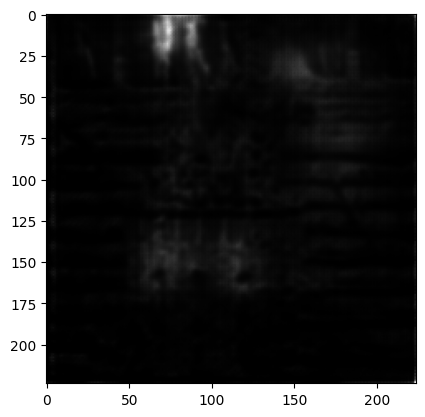

In [29]:
plt.imshow(res[0], cmap='grey')

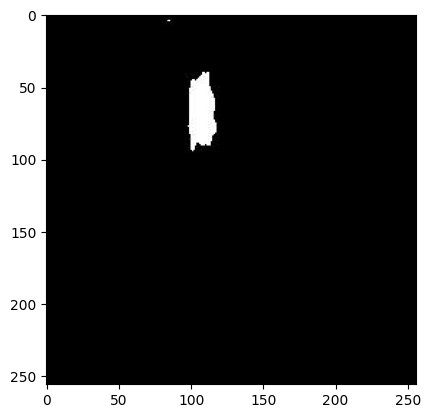

In [32]:
orig = cv2.imread('./dataset/val_mask/Fire/Img_0.jpg')
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(orig)

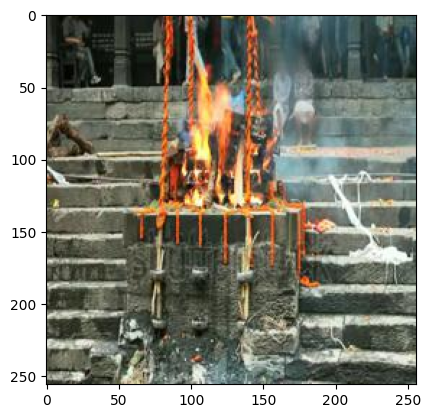

In [31]:
actual=cv2.imread('./dataset/val_image/Fire/Img_0.jpg')
actual = cv2.cvtColor(actual, cv2.COLOR_BGR2RGB)
plt.imshow(actual)